Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 5.3848e-07 - loss: 0.6917 - val_accuracy: 0.0000e+00 - val_loss: 0.6917
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 2.2556e-08 - loss: 0.6906 - val_accuracy: 0.0000e+00 - val_loss: 0.6912
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 4.7123e-06 - loss: 0.6898 - val_accuracy: 3.3171e-06 - val_loss: 0.6904
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 1.8086e-05 - loss: 0.6921 - val_accuracy: 5.7055e-05 - val_loss: 0.6900
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 8.0925e-05 - loss: 0.6887 - val_accuracy: 5.7055e-05 - val_loss: 0.6879
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 1.1764e-04 - loss: 0.6865 - val_accuracy: 5.7055e-05 - val_loss: 0.6878
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 6.3253e-05 - loss: 0.6836 - val_accuracy: 5.7055e-05 - val_loss: 0.6828
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - ac

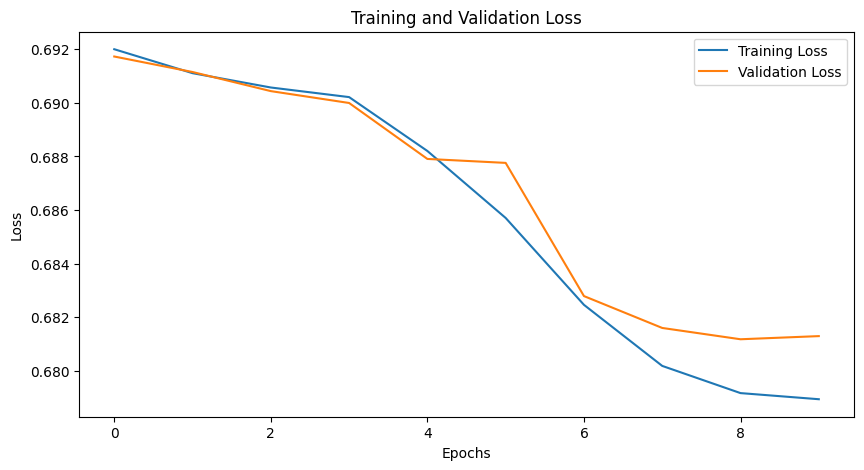

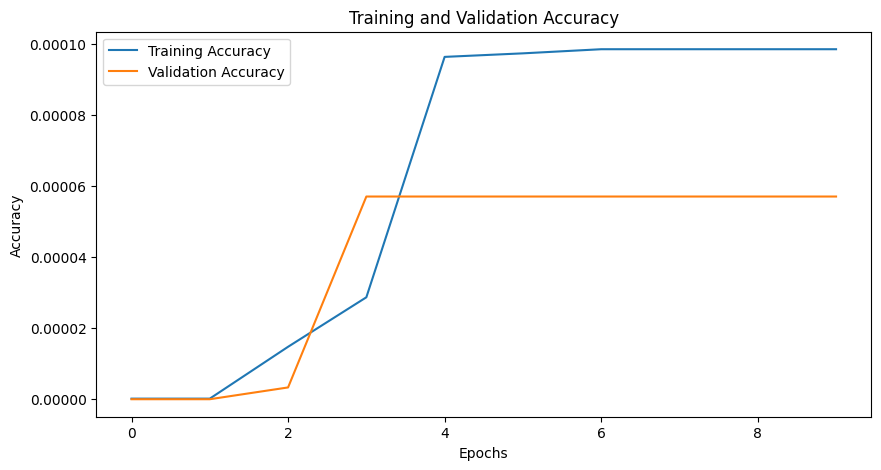

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths for the dataset and output
TRAINING_DATA_PATH = '/Users/niccolozoboli/Desktop/DIC-C2DH-HeLa/01/'
TEST_DATA_PATH = '/Users/niccolozoboli/Desktop/DIC-C2DH-HeLa/02/'
OUTPUT_DIR = '/Users/niccolozoboli/Desktop/DIC-C2DH-HeLa/predictions/'

# Function to load images from a directory
def load_images_from_dir(directory, resize_shape=(256, 256)):
    images = []
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")
    for file in sorted(os.listdir(directory)):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path) and file.endswith('.tif'):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, resize_shape)
                images.append(img)
            else:
                print(f"Warning: Unable to read {file_path}. Skipping.")
    return np.array(images)

# Load training and testing images
train_images = load_images_from_dir(TRAINING_DATA_PATH)
test_images = load_images_from_dir(TEST_DATA_PATH)

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Create masks for training (for testing purposes, masks are the same as the images)
train_masks = train_images

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Define the U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the U-Net model
model = unet_model()

# Train the model and save the training history
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=1)

# Predict on test images
predictions = model.predict(test_images)

# Save predictions to the output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
for i, pred in enumerate(predictions):
    pred_img = (pred.squeeze() * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(OUTPUT_DIR, f'prediction_{i}.png'), pred_img)

print(f"Predictions saved in {OUTPUT_DIR}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
